Get recommendation from song input based on model.pickle. 

In [1]:
from songrecommender import get_song_df, showID_in_player
from scalingclustering import load_pkl, predict_kmeans
import pandas as pd
from IPython.display import IFrame
from harmonicneighbours import translate_pc_cam, translate_cam_pc, harmonic_sibbling

1. read song_result
2. search song on spotify
3. get audio features of song
4. import pickle model
5. predict cluster of song
6. chose possible songs from cluster
7. run harmonic mixing to filter possible songs


## 1. read song_result ## 2. search song on spotify ## 3. get audio features of song

In [2]:
song_df = get_song_df()

The artist of your song: alcoholic


## 4. import pickle model

In [3]:
scaler = load_pkl(filename='model/scalerKmeans.pickle')
kmeans = load_pkl(filename = 'model/modelKmeans.pickle')
X = load_pkl(filename=  'model/X.pickle')
X_scaled_df = load_pkl(filename ='model/X_scaled_df')
sp_library = load_pkl(filename ='model/sp_library.pickle')

## 5. scale song_df

In [4]:
song_df['Year'] = pd.to_datetime(song_df['ReleaseYear'], format='%Y-%m-%d')
song_df['Year'] = pd.DatetimeIndex(song_df['Year']).year

In [5]:
song_df_scaled = scaler.transform(song_df[X_scaled_df.columns])

C:\Users\Lenovo\anaconda3\envs\DA_Env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


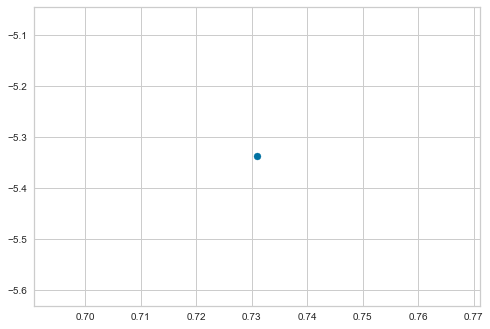

In [6]:
song_label, song_cluster = predict_kmeans(song_df_scaled, X, kmeans)

In [7]:
song_df['label'] = song_label

## Get song suggestion from same cluster and show spotify player

### Key/mode: Get harmonic neighbours:

In [8]:
song_key = song_df['key'].iloc[0]
song_mode = song_df['mode'].iloc[0]
song_key, song_mode

(9, 0)

Translate key and mode to camelot:

In [13]:
key_cam

['11B']

In [12]:
key_cam = translate_pc_cam(song_key, song_mode)


IndexError: list index out of range

Get neighbours:

In [10]:
neighbours = harmonic_sibbling(key_cam)

IndexError: list index out of range

In [ ]:
neighbours

In [ ]:
for neighbour in neighbours:
    translate_cam_pc(neighbour)

In [ ]:
song_suggest_cluster = sp_library[sp_library['label']==song_df['label'][0]]

In [ ]:

song_suggest_TrackID = song_suggest['TrackID'].iloc[0]

## Comparing songs

In [ ]:
df_compair = pd.concat([song_df, song_suggest], axis=0)
df_compair.iloc[:,0:9]

In [ ]:
df_compair.iloc[:,10:19]

In [ ]:
player_user_choice = showID_in_player(song_df.loc[0, 'TrackID'])
print(f'This is your recommendation:')
player_user_choice

In [ ]:
player_recommendation = showID_in_player(song_suggest_TrackID)
print(f'This is your recommendation:')
player_recommendation
